In [2]:
# importing the necessary libraries:
import warnings
warnings.filterwarnings("ignore")
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import leidenalg
import scipy.sparse as sp
import math
import gseapy as gp

In [3]:
neu = sc.read("../data/merged_neu_with_blob.h5ad")

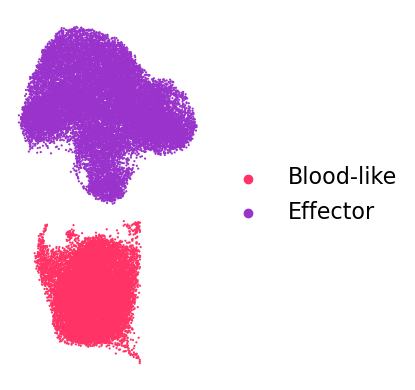

In [4]:
fig, ax = plt.subplots(figsize=(4, 4))
sc.pl.umap(
    neu,
    color="blob",
    palette={
        "Blood-like": "#FF3366",
        "Effector": "#9933CC",
    },
    ax=ax,
    #na_color=fallback,
    na_in_legend=True,
    legend_fontsize=16,
    legend_fontoutline=2,
    add_outline=False,
    size=10,
    show=False,
)

ax.set(xlabel="", ylabel="")
ax.title.set_visible(False)
ax.set_axis_off()
ax.set_aspect(1.0)
fig.tight_layout()
plt.show()

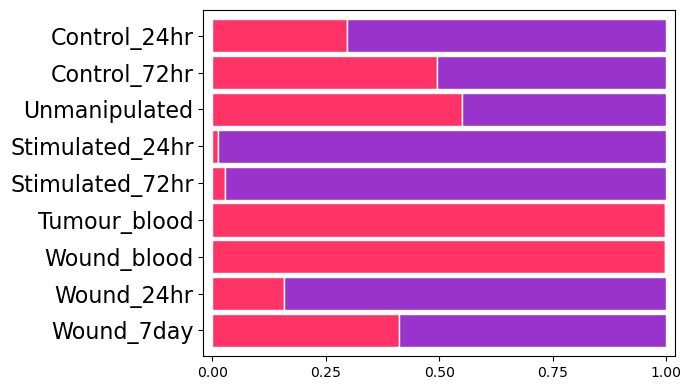

In [5]:
# Step 1: Define the raw data
data = {
   
    "Blood_like": {"Control_24hr":452 , "Control_72hr":1432, "Unmanipulated":1283,
                    "Stimulated_24hr":77 , "Stimulated_72hr":169, "Tumour_blood":4539,
                   "Wound_blood": 5324, "Wound_24hr": 836, "Wound_7day": 107},
     "Effector": {"Control_24hr":1068, "Control_72hr":1459 , "Unmanipulated":1049,
                  "Stimulated_24hr":6070, "Stimulated_72hr":6047, "Tumour_blood":4,
                  "Wound_blood": 14, "Wound_24hr": 4489, "Wound_7day": 153}
}

order = ["Control_24hr","Control_72hr","Unmanipulated",
         "Stimulated_24hr","Stimulated_72hr","Tumour_blood",
         "Wound_blood","Wound_24hr","Wound_7day"]

# Build DF in your desired row order
df = pd.DataFrame(data).reindex(order)

# (optional) also fix column order to match your colors
col_order = ["Blood_like", "Effector"]
fractions = df[col_order].div(df.sum(axis=1), axis=0)

ax = fractions.plot(
    kind="barh", stacked=True, figsize=(7,4), width=0.9, edgecolor="white",
    color=["#FF3366","#9933CC"]  # Blood_like, Effector
)

# Put the first row at the TOP
ax.invert_yaxis()

# Step 5: Style 
ax.set_xlim(0, 1) 
ax.set_xticks([0.0, 0.25, 0.5, 0.75, 1.0]) 
ax.set_xticklabels(['0.00', '0.25', '0.50', '0.75', '1.00']) 
ax.set_xlim(-0.02, 1.02)
ax.tick_params(axis='y', labelsize=16) 
# Clean layout 
ax.set_xlabel('')
ax.set_ylabel('') 
ax.set_title('') 
ax.legend().remove() 
plt.tight_layout() 
plt.show()

In [6]:
# 0) See what labels you currently have
print("Unique blob labels:", neu.obs["blob"].unique())

Unique blob labels: ['Effector', 'Blood-like']
Categories (2, object): ['Blood-like', 'Effector']


In [7]:
# Subset first
neu = neu[neu.obs["blob"].isin(["Blood-like","Effector"])].copy()
print("\nCounts after subsetting:\n", neu.obs["blob"].value_counts())
# Run DE
sc.tl.rank_genes_groups(
    neu,
    groupby="blob",
    method="wilcoxon",
    use_raw=False,
    layer="log1p"
)


Counts after subsetting:
 blob
Effector      20353
Blood-like    14219
Name: count, dtype: int64


In [8]:
# (optional) quick check that the layer exists
if "log1p" not in neu.layers:
    raise ValueError("Missing 'log1p' layer. Create it or choose another layer.")

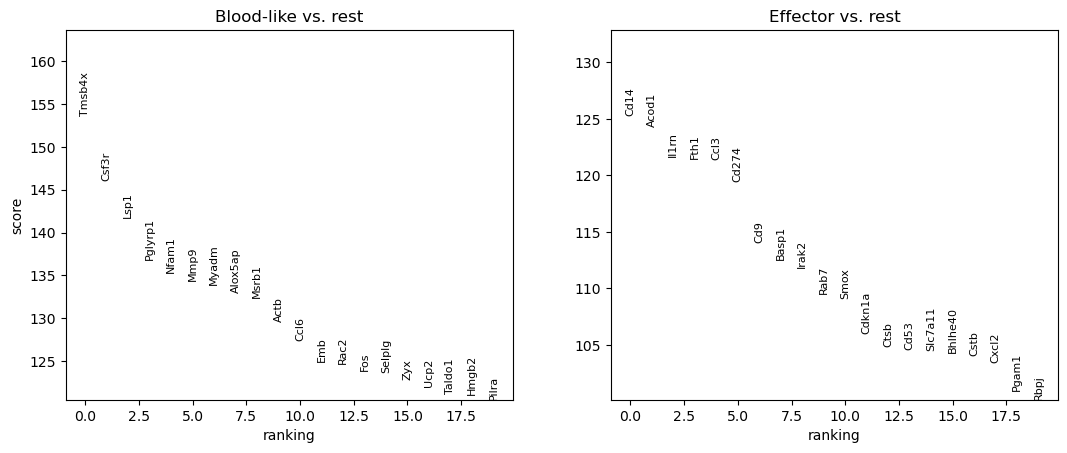

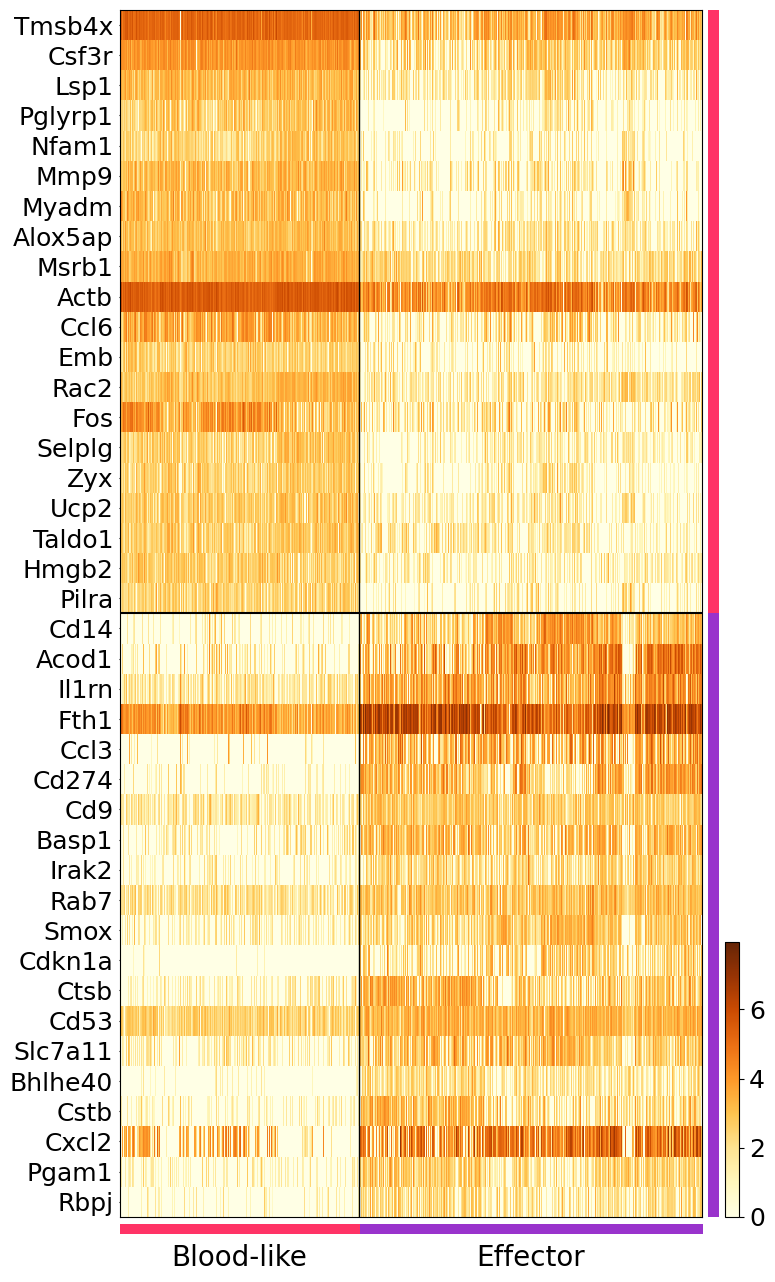

In [9]:
# 2) Run DE on the same layer you'll plot
#sc.tl.rank_genes_groups(neu,groupby="blob",method="wilcoxon",use_raw=False,layer="log1p",)

# 3) Quick plots
sc.pl.rank_genes_groups(neu, n_genes=20, sharey=False, show=False)
plt.show()
sc.pl.rank_genes_groups_heatmap(
    neu,
    n_genes=20,
    groupby='blob',
    swap_axes=True,
    cmap="YlOrBr",
    dendrogram=False,
    show_gene_labels=True,
    use_raw=False,
    layer="log1p",
    figsize=(8, 16),
    show=False
)


fig = plt.gcf()
for ax in fig.axes:
    if ax.get_xticklabels():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=20)
    if ax.get_ylabel() == '':
        ax.tick_params(axis='y', labelsize=18)
    if ax.get_xlabel() == "blob":
        ax.set_xlabel("")
axes = fig.get_axes()
axes[0].axhline(19.5, color="black")
#axes[0].axvline(6350.5, color="black", linewidth=0.7)
plt.tight_layout()
plt.show()


In [10]:
# 4) Tidy tables → save all + significant only (FDR < 0.05)
de_all = sc.get.rank_genes_groups_df(neu, group=None)
de_all.to_csv("DE_all_groups.csv", index=False)

de_sig = de_all[de_all["pvals_adj"] < 0.05]
de_sig.to_csv("DE_all_groups_significant.csv", index=False)

print("\nRows in DE_all:", len(de_all))
print("Rows in DE_all_significant (FDR<0.05):", len(de_sig))


Rows in DE_all: 54858
Rows in DE_all_significant (FDR<0.05): 11684


In [11]:
# 5) Pick one TOP up-regulated gene for 'Effector'
deE = sc.get.rank_genes_groups_df(neu, group="Effector")
deE_up = deE[deE["logfoldchanges"] > 0].sort_values(
    ["pvals_adj", "scores"], ascending=[True, False]
)
top_gene = deE_up.iloc[0]["names"]
print("\nTop up gene for Effector:", top_gene)


Top up gene for Effector: Cd14


In [12]:
# 5) Pick one TOP up-regulated gene for 'Blood-like'
deB = sc.get.rank_genes_groups_df(neu, group="Blood-like")
deB_up = deB[deB["logfoldchanges"] > 0].sort_values(
    ["pvals_adj", "scores"], ascending=[True, False]
)
top_gene = deB_up.iloc[0]["names"]
print("\nTop up gene for Blood-like:", top_gene)


Top up gene for Blood-like: Tmsb4x


In [13]:
# 6) Mean expression (same layer) of that gene in each group
def mean_in_group(adata, gene, group, layer="log1p"):
    # take the one-gene column from the chosen layer
    col = adata[:, gene].layers[layer]
    # turn into a 1D numpy array
    if hasattr(col, "toarray"):
        col = col.toarray().ravel()
    else:
        col = np.array(col).ravel()
    # mask for the group
    mask = (adata.obs["blob"] == group).values
    return float(col[mask].mean())

m_e = mean_in_group(neu, top_gene, "Effector")
m_b = mean_in_group(neu, top_gene, "Blood-like")
print(f"{top_gene} mean(log1p) → Effector: {m_e:.3f}, Blood-like: {m_b:.3f}")

Tmsb4x mean(log1p) → Effector: 3.157, Blood-like: 5.190


In [14]:
genes = ["Cd14", "Acod1", "Il1rn", "Fth1"]  # edit this list

rows = []
for g in genes:
    if g not in neu.var_names:
        rows.append({"gene": g, "note": "not in var_names"})
        continue
    col = neu[:, g].layers["log1p"]
    col = col.toarray().ravel() if hasattr(col, "toarray") else np.asarray(col).ravel()
    maskE = (neu.obs["blob"] == "Effector").values
    maskB = (neu.obs["blob"] == "Blood-like").values
    rows.append({
        "gene": g,
        "mean_Effector": float(col[maskE].mean()),
        "mean_Blood-like": float(col[maskB].mean()),
        "pctExpr_Effector": float((col[maskE] > 0).mean() * 100),
        "pctExpr_Blood-like": float((col[maskB] > 0).mean() * 100),
        "Δmean_log1p (E-B)": float(col[maskE].mean() - col[maskB].mean()),
    })

summary = pd.DataFrame(rows)
print(summary)

    gene  mean_Effector  mean_Blood-like  pctExpr_Effector  \
0   Cd14       2.718203         0.335719         86.449172   
1  Acod1       3.351831         0.557637         87.962463   
2  Il1rn       3.414762         1.368586         94.354641   
3   Fth1       5.499744         3.741780         99.734683   

   pctExpr_Blood-like  Δmean_log1p (E-B)  
0           18.925382           2.382484  
1           27.406991           2.794194  
2           71.875659           2.046176  
3           99.240453           1.757964  


** calculating the approximate up/down in Activated **

In [14]:
#for Cd14
mean_E = 2.718203
mean_B = 0.335719
delta = mean_E - mean_B
fold_like = math.exp(delta)
print(f"Δmean_log1p = {delta:.3f}  → ~{fold_like:.1f}× higher in Effector")

Δmean_log1p = 2.382  → ~10.8× higher in Effector


In [15]:

genes = ["Tmsb4x", "Csf3r", "Lsp1"]
rows = []
for g in genes:
    if g not in neu.var_names:
        rows.append({"gene": g, "note": "not in var_names"})
        continue
    col = neu[:, g].layers["log1p"]
    col = col.toarray().ravel() if hasattr(col, "toarray") else np.asarray(col).ravel()
    maskE = (neu.obs["blob"] == "Effector").values
    maskB = (neu.obs["blob"] == "Blood-like").values
    rows.append({
        "gene": g,
        "mean_Effector": float(col[maskE].mean()),
        "mean_Blood-like": float(col[maskB].mean()),
        "pctExpr_Effector": float((col[maskE] > 0).mean() * 100),
        "pctExpr_Blood-like": float((col[maskB] > 0).mean() * 100),
        "Δmean_log1p (E-B)": float(col[maskE].mean() - col[maskB].mean()),
    })

summary = pd.DataFrame(rows)
print(summary)

     gene  mean_Effector  mean_Blood-like  pctExpr_Effector  \
0  Tmsb4x       3.156949         5.190048         95.234118   
1   Csf3r       1.993453         3.992332         79.093991   
2    Lsp1       1.279221         3.229070         65.179580   

   pctExpr_Blood-like  Δmean_log1p (E-B)  
0           99.978901          -2.033100  
1           99.929672          -1.998879  
2           99.599128          -1.949849  


In [16]:
import math

mean_E = 3.156949
mean_B = 5.190048
delta = abs(mean_E - mean_B)
fold_like = math.exp(delta)
print(f"Δmean_log1p = {delta:.3f}  → ~{fold_like:.1f}× higher in Blood-like")

Δmean_log1p = 2.033  → ~7.6× higher in Blood-like


*pathway enrichment analysis between Activated and Circulating*

In [28]:
up_in_Effector = de_sig.query("group == 'Effector' and logfoldchanges > 0")["names"].tolist()
up_in_Blood = de_sig.query("group == 'Blood-like' and logfoldchanges > 0")["names"].tolist()

genes_up_Effector = up_in_Effector[:150]
genes_up_Blood = up_in_Blood[:150]

print("Top Effector genes:", len(genes_up_Effector))
print("Top Blood-like genes:", len(genes_up_Blood))

Top Effector genes: 150
Top Blood-like genes: 150


In [29]:
# Run Enrichr
import gseapy as gp

enr_upE = gp.enrichr(
    gene_list=genes_up_Effector,
    gene_sets=["KEGG_2019_Mouse", "GO_Biological_Process_2023"],
    organism="mouse",
    outdir=None,
)

enr_upB = gp.enrichr(
    gene_list=genes_up_Blood,
    gene_sets=["KEGG_2019_Mouse", "GO_Biological_Process_2023"],
    organism="mouse",
    outdir=None,
)


In [30]:
# Extract and tidy the results
def extract_pathways(enr_result, gene_set_name, label, top_n=50):
    df = enr_result.results.copy()
    df = df[df["Gene_set"] == gene_set_name]
    df["-log10(FDR)"] = -np.log10(df["Adjusted P-value"].clip(lower=1e-300))
    df = df.nsmallest(top_n, "Adjusted P-value")
    df["Condition"] = label
    return df

# KEGG
kegg_E = extract_pathways(enr_upE, "KEGG_2019_Mouse", "up in effector")
kegg_B = extract_pathways(enr_upB, "KEGG_2019_Mouse", "up in blood-like")


# GO-BP
go_E = extract_pathways(enr_upE, "GO_Biological_Process_2023", "up in effector")
go_E["Term"] = go_E["Term"].str.replace(r"\s*\(GO:\d+\)", "", regex=True)
go_B = extract_pathways(enr_upB, "GO_Biological_Process_2023", "up in blood-like")
go_B["Term"] = go_B["Term"].str.replace(r"\s*\(GO:\d+\)", "", regex=True)

In [31]:
# plotting
import seaborn as sns
palette = {"up in effector": "#9933CC", "up in blood-like": "#FF3366"}

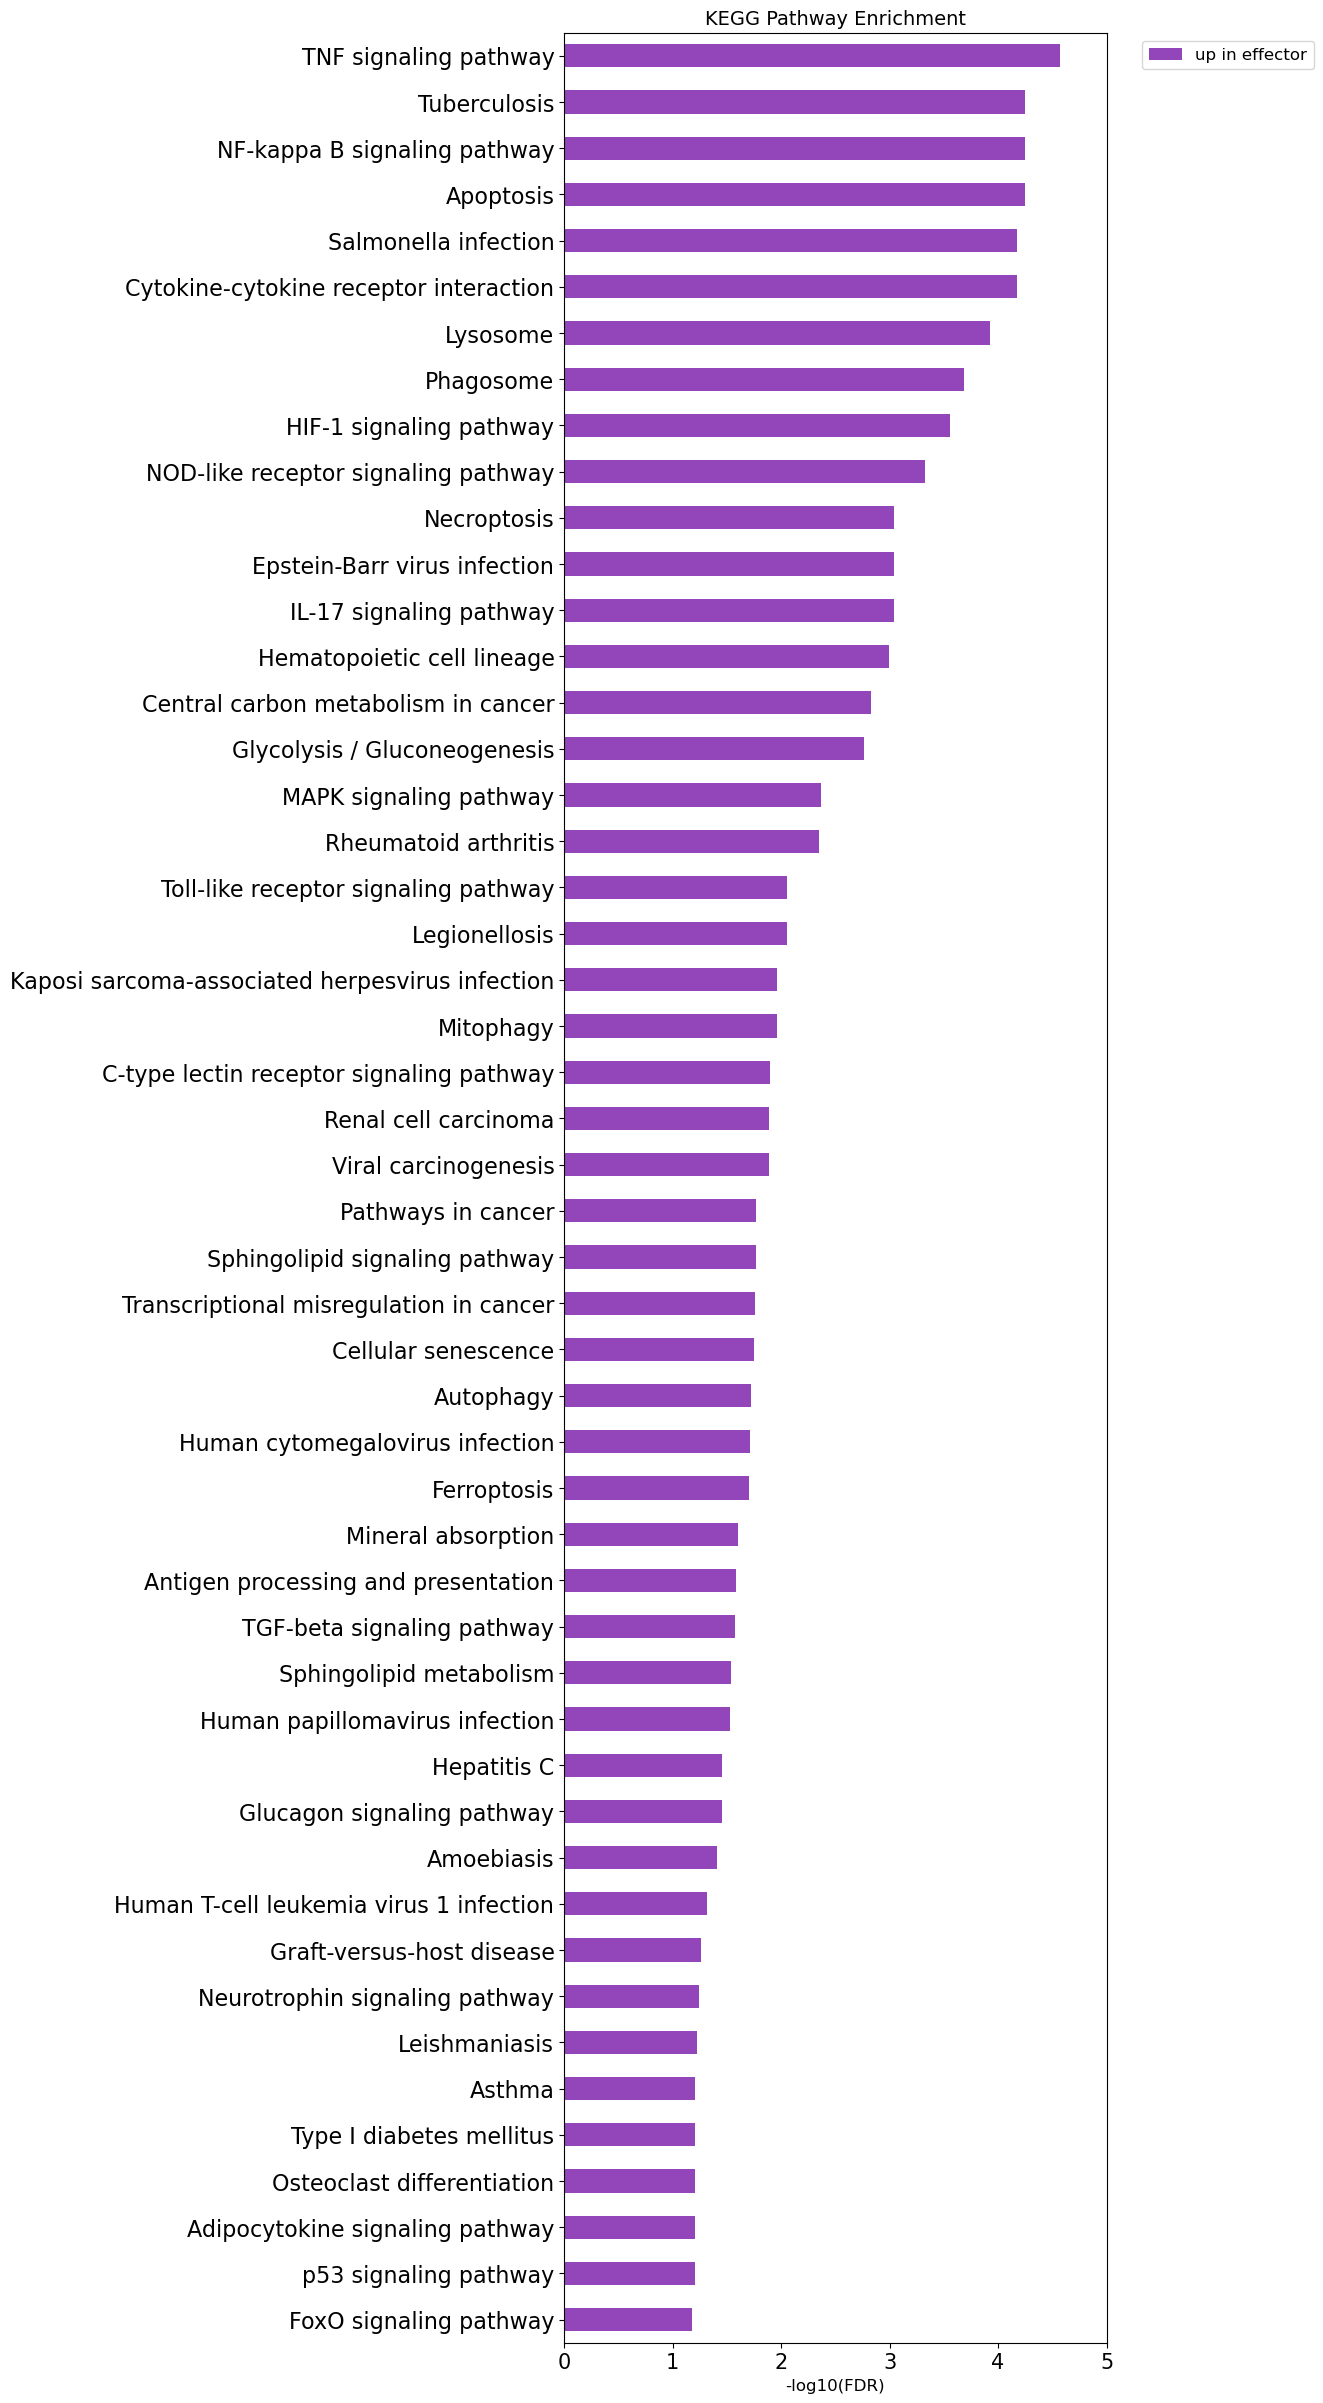

In [32]:
# Plot KEGG
plt.figure(figsize=(7, 30))
ax = sns.barplot(
    data=kegg_E,
    x="-log10(FDR)",
    y="Term",
    hue="Condition",
    palette=palette
)

# --- make bars thinner but keep them centred on the tick labels ---
new_h = 0.5  # bar thickness you want
for bar in ax.patches:
    old_y = bar.get_y()
    old_h = bar.get_height()
    center = old_y + old_h / 2.0      # current centre of the bar
    bar.set_height(new_h)             # new height
    bar.set_y(center - new_h / 2.0)   # move so centre stays the same
# ------------------------------------------------------------------

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.title("KEGG Pathway Enrichment", fontsize=14)
plt.xlabel("-log10(FDR)", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.ylabel("")

xmax = ax.get_xlim()[1]
plt.xticks(ticks=np.arange(0, int(np.ceil(xmax)) + 0.1, 1), fontsize=15)

plt.show()

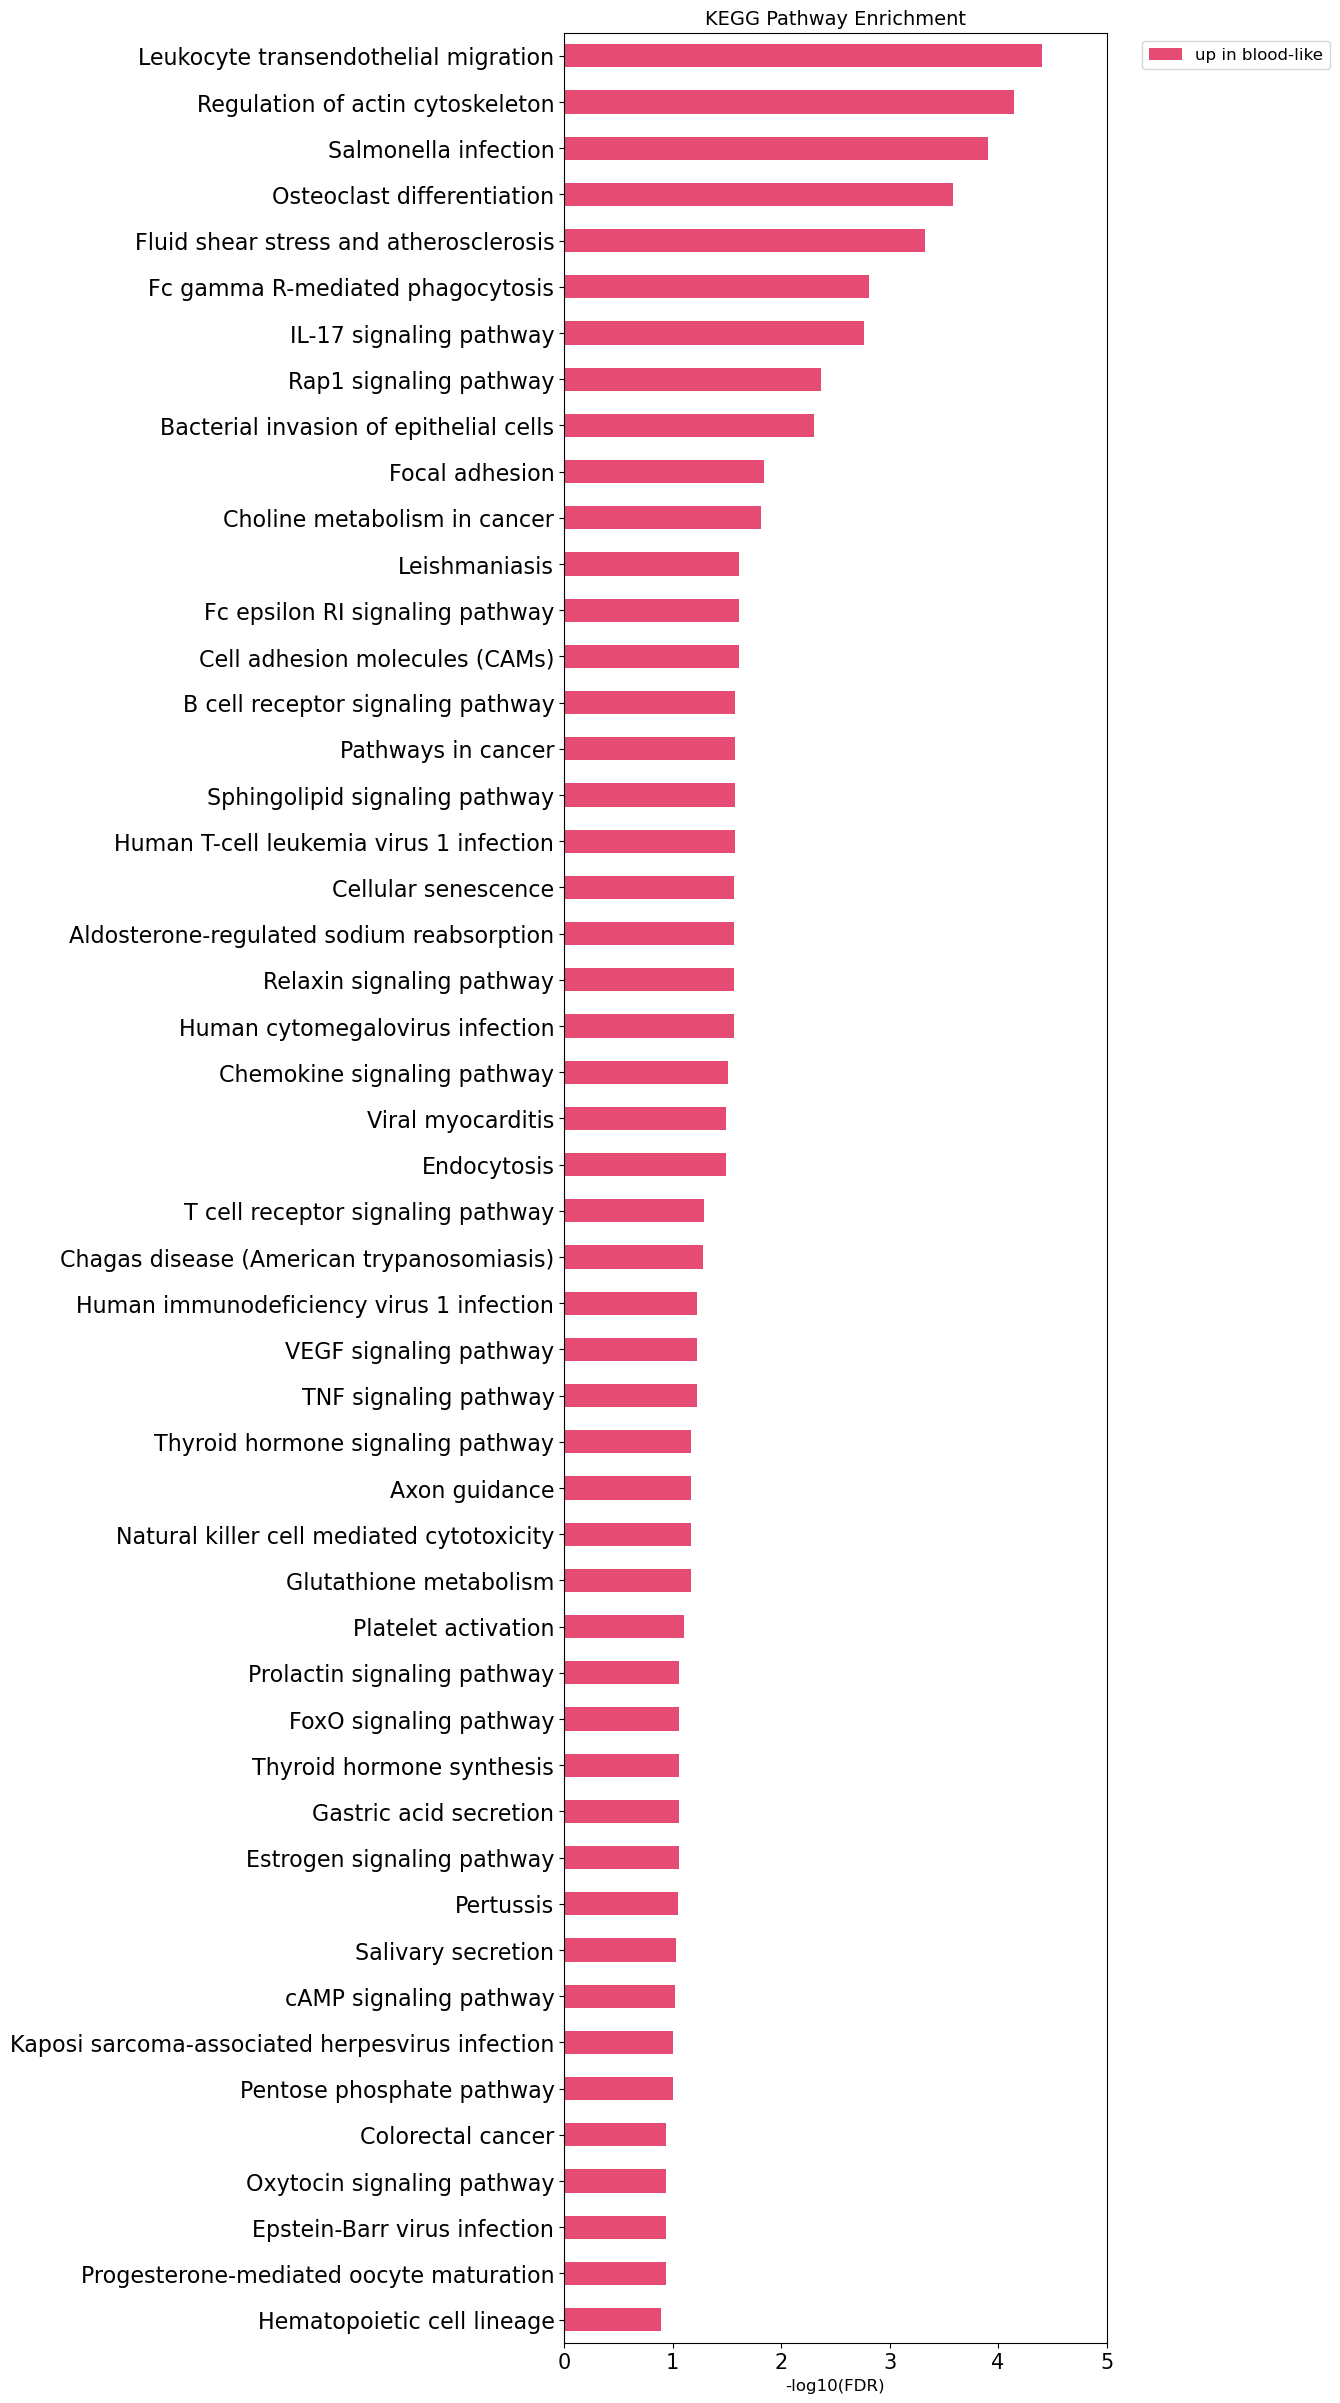

In [33]:
# Plot KEGG
plt.figure(figsize=(7, 30))
ax = sns.barplot(
    data=kegg_B,
    x="-log10(FDR)",
    y="Term",
    hue="Condition",
    palette=palette
)

# --- make bars thinner but keep them centred on the tick labels ---
new_h = 0.5  # bar thickness you want
for bar in ax.patches:
    old_y = bar.get_y()
    old_h = bar.get_height()
    center = old_y + old_h / 2.0      # current centre of the bar
    bar.set_height(new_h)             # new height
    bar.set_y(center - new_h / 2.0)   # move so centre stays the same
# ------------------------------------------------------------------

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.title("KEGG Pathway Enrichment", fontsize=14)
plt.xlabel("-log10(FDR)", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.ylabel("")

xmax = ax.get_xlim()[1]
plt.xticks(ticks=np.arange(0, int(np.ceil(xmax)) + 0.1, 1), fontsize=15)

plt.show()

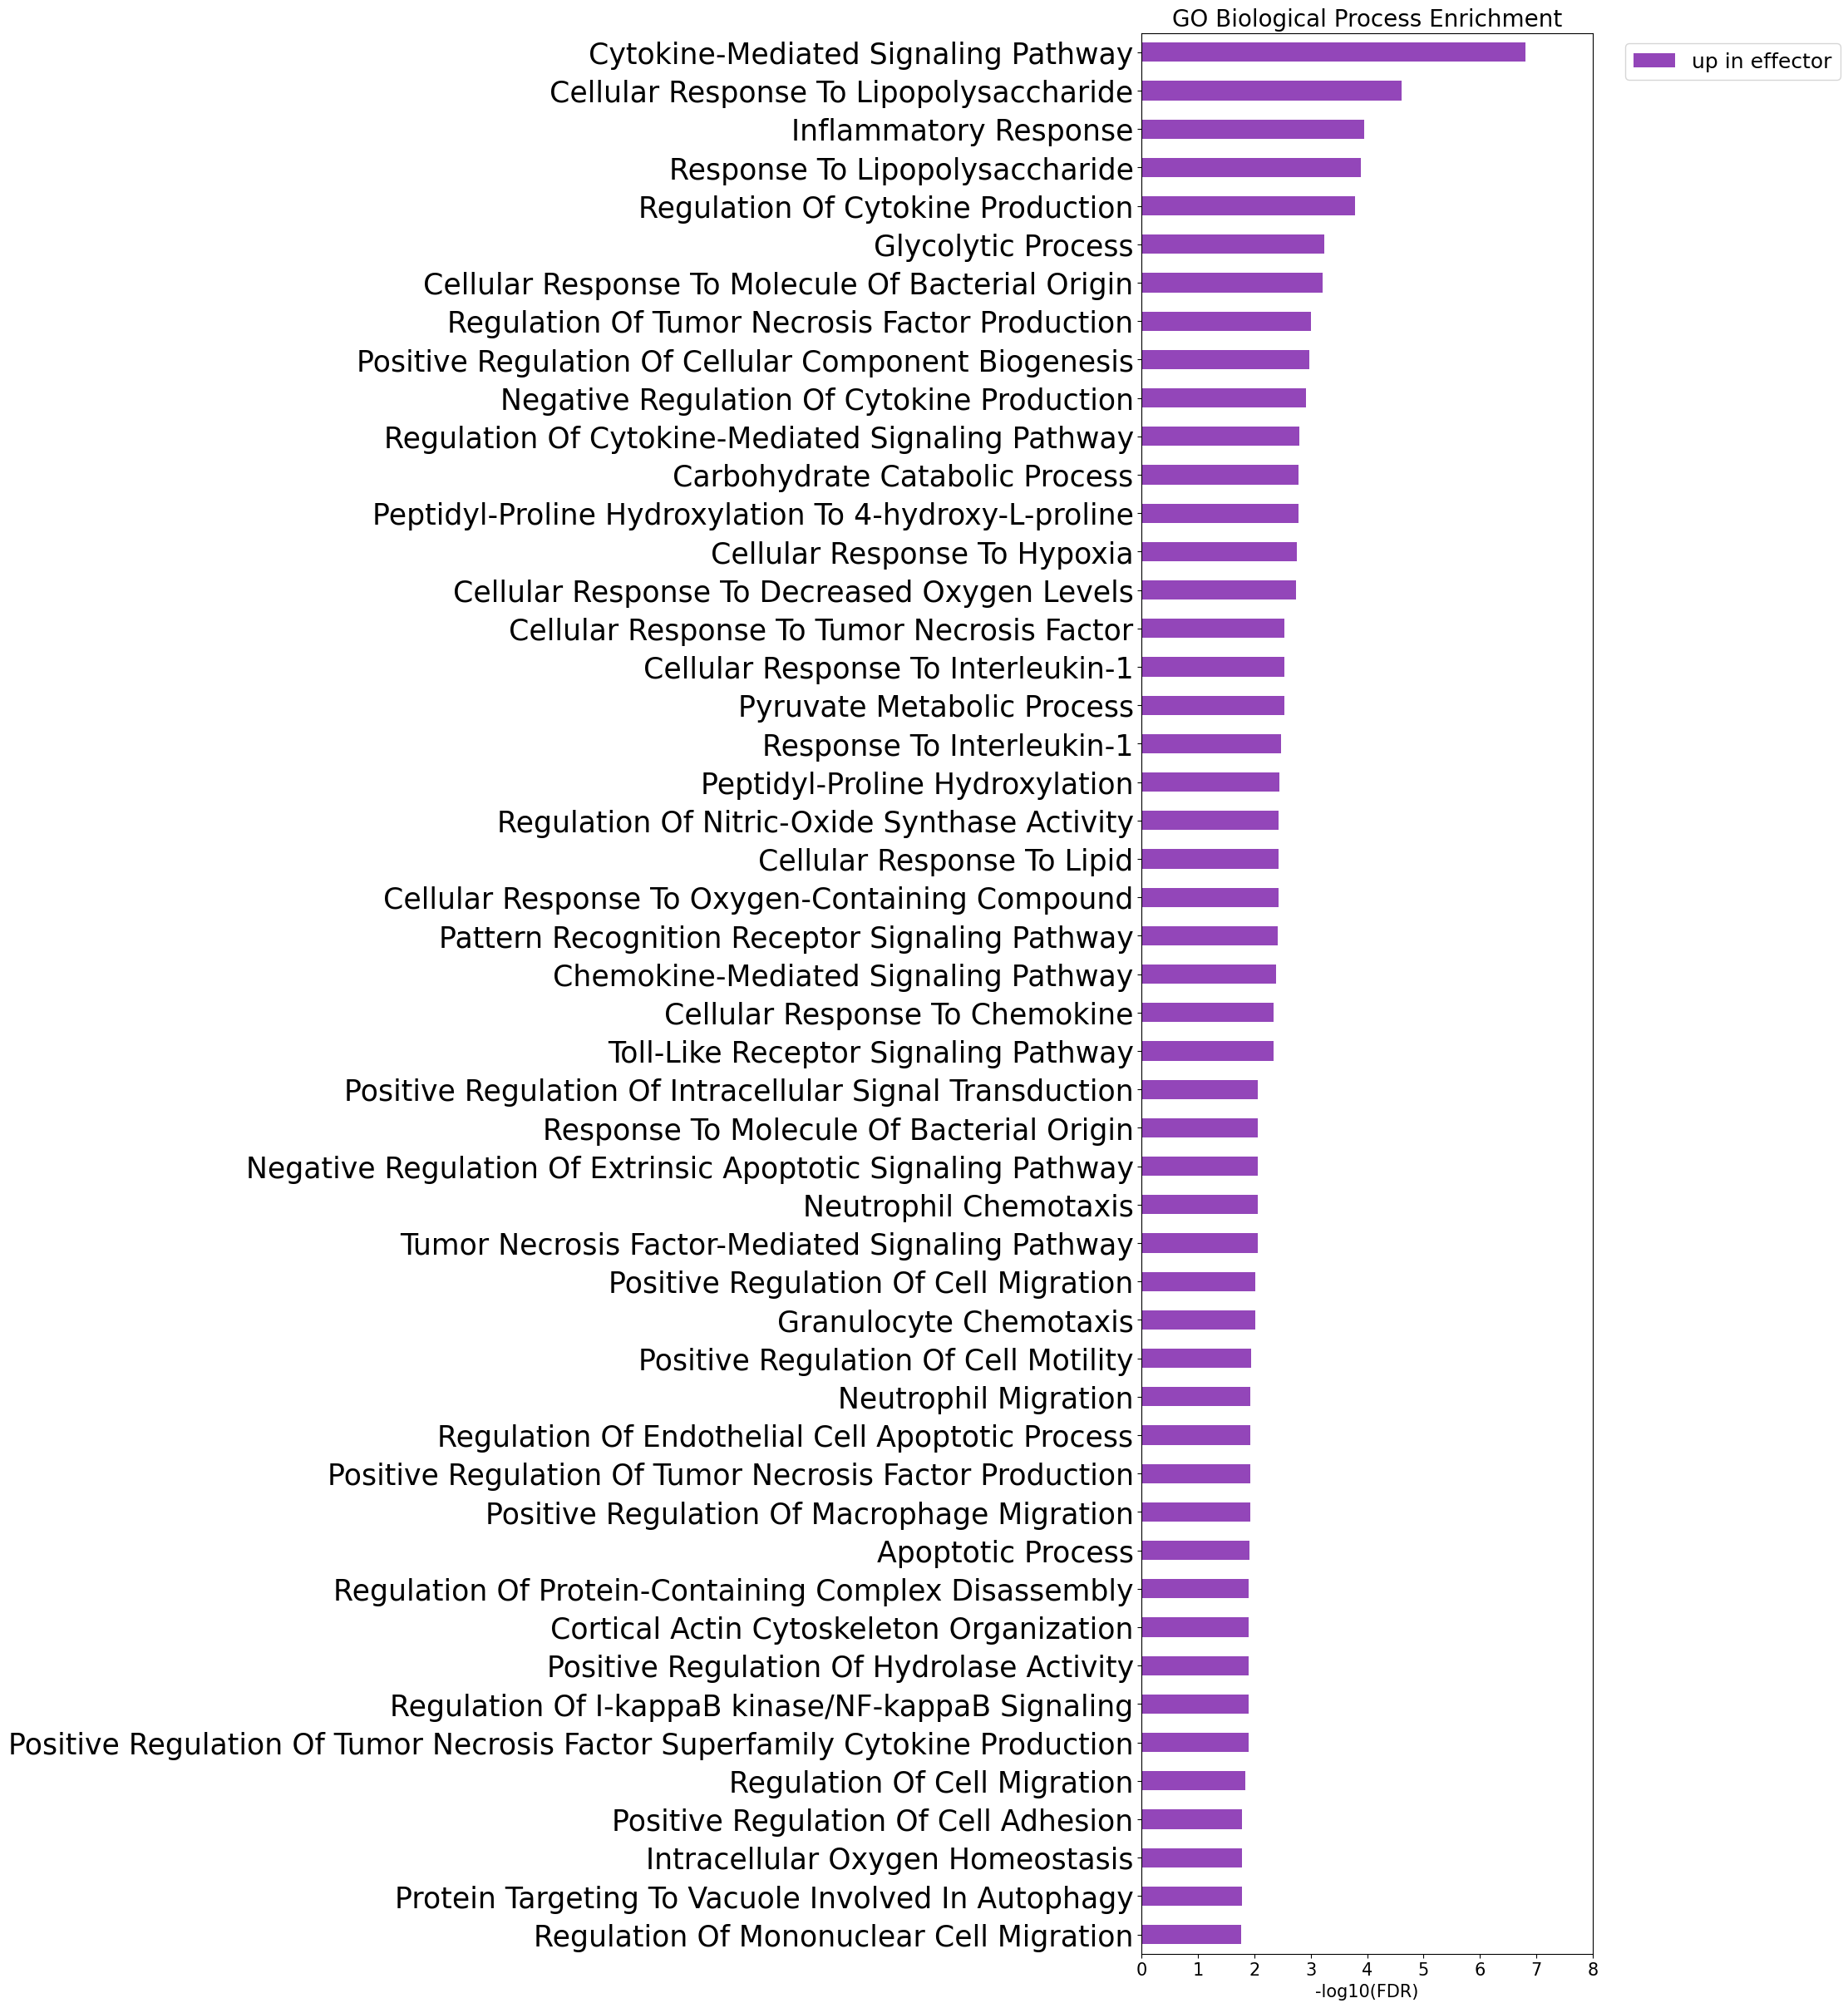

In [34]:
# Plot GO-BP
plt.figure(figsize=(7, 30))
ax = sns.barplot(
    data=go_E,
    x="-log10(FDR)",
    y="Term",
    hue="Condition",
    palette=palette
)

# --- make bars thinner but keep them centred on the tick labels ---
new_h = 0.5  # bar thickness you want
for bar in ax.patches:
    old_y = bar.get_y()
    old_h = bar.get_height()
    center = old_y + old_h / 2.0      # current centre of the bar
    bar.set_height(new_h)             # new height
    bar.set_y(center - new_h / 2.0)   # move so centre stays the same
# ------------------------------------------------------------------

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=18)
plt.title("GO Biological Process Enrichment", fontsize=20)
plt.xlabel("-log10(FDR)", fontsize=15)
plt.ylabel("")
plt.xticks(fontsize=15)
plt.yticks(fontsize=25)

xmax = ax.get_xlim()[1]
plt.xticks(ticks=np.arange(0, int(np.ceil(xmax)) + 0.1, 1), fontsize=15)

plt.show()

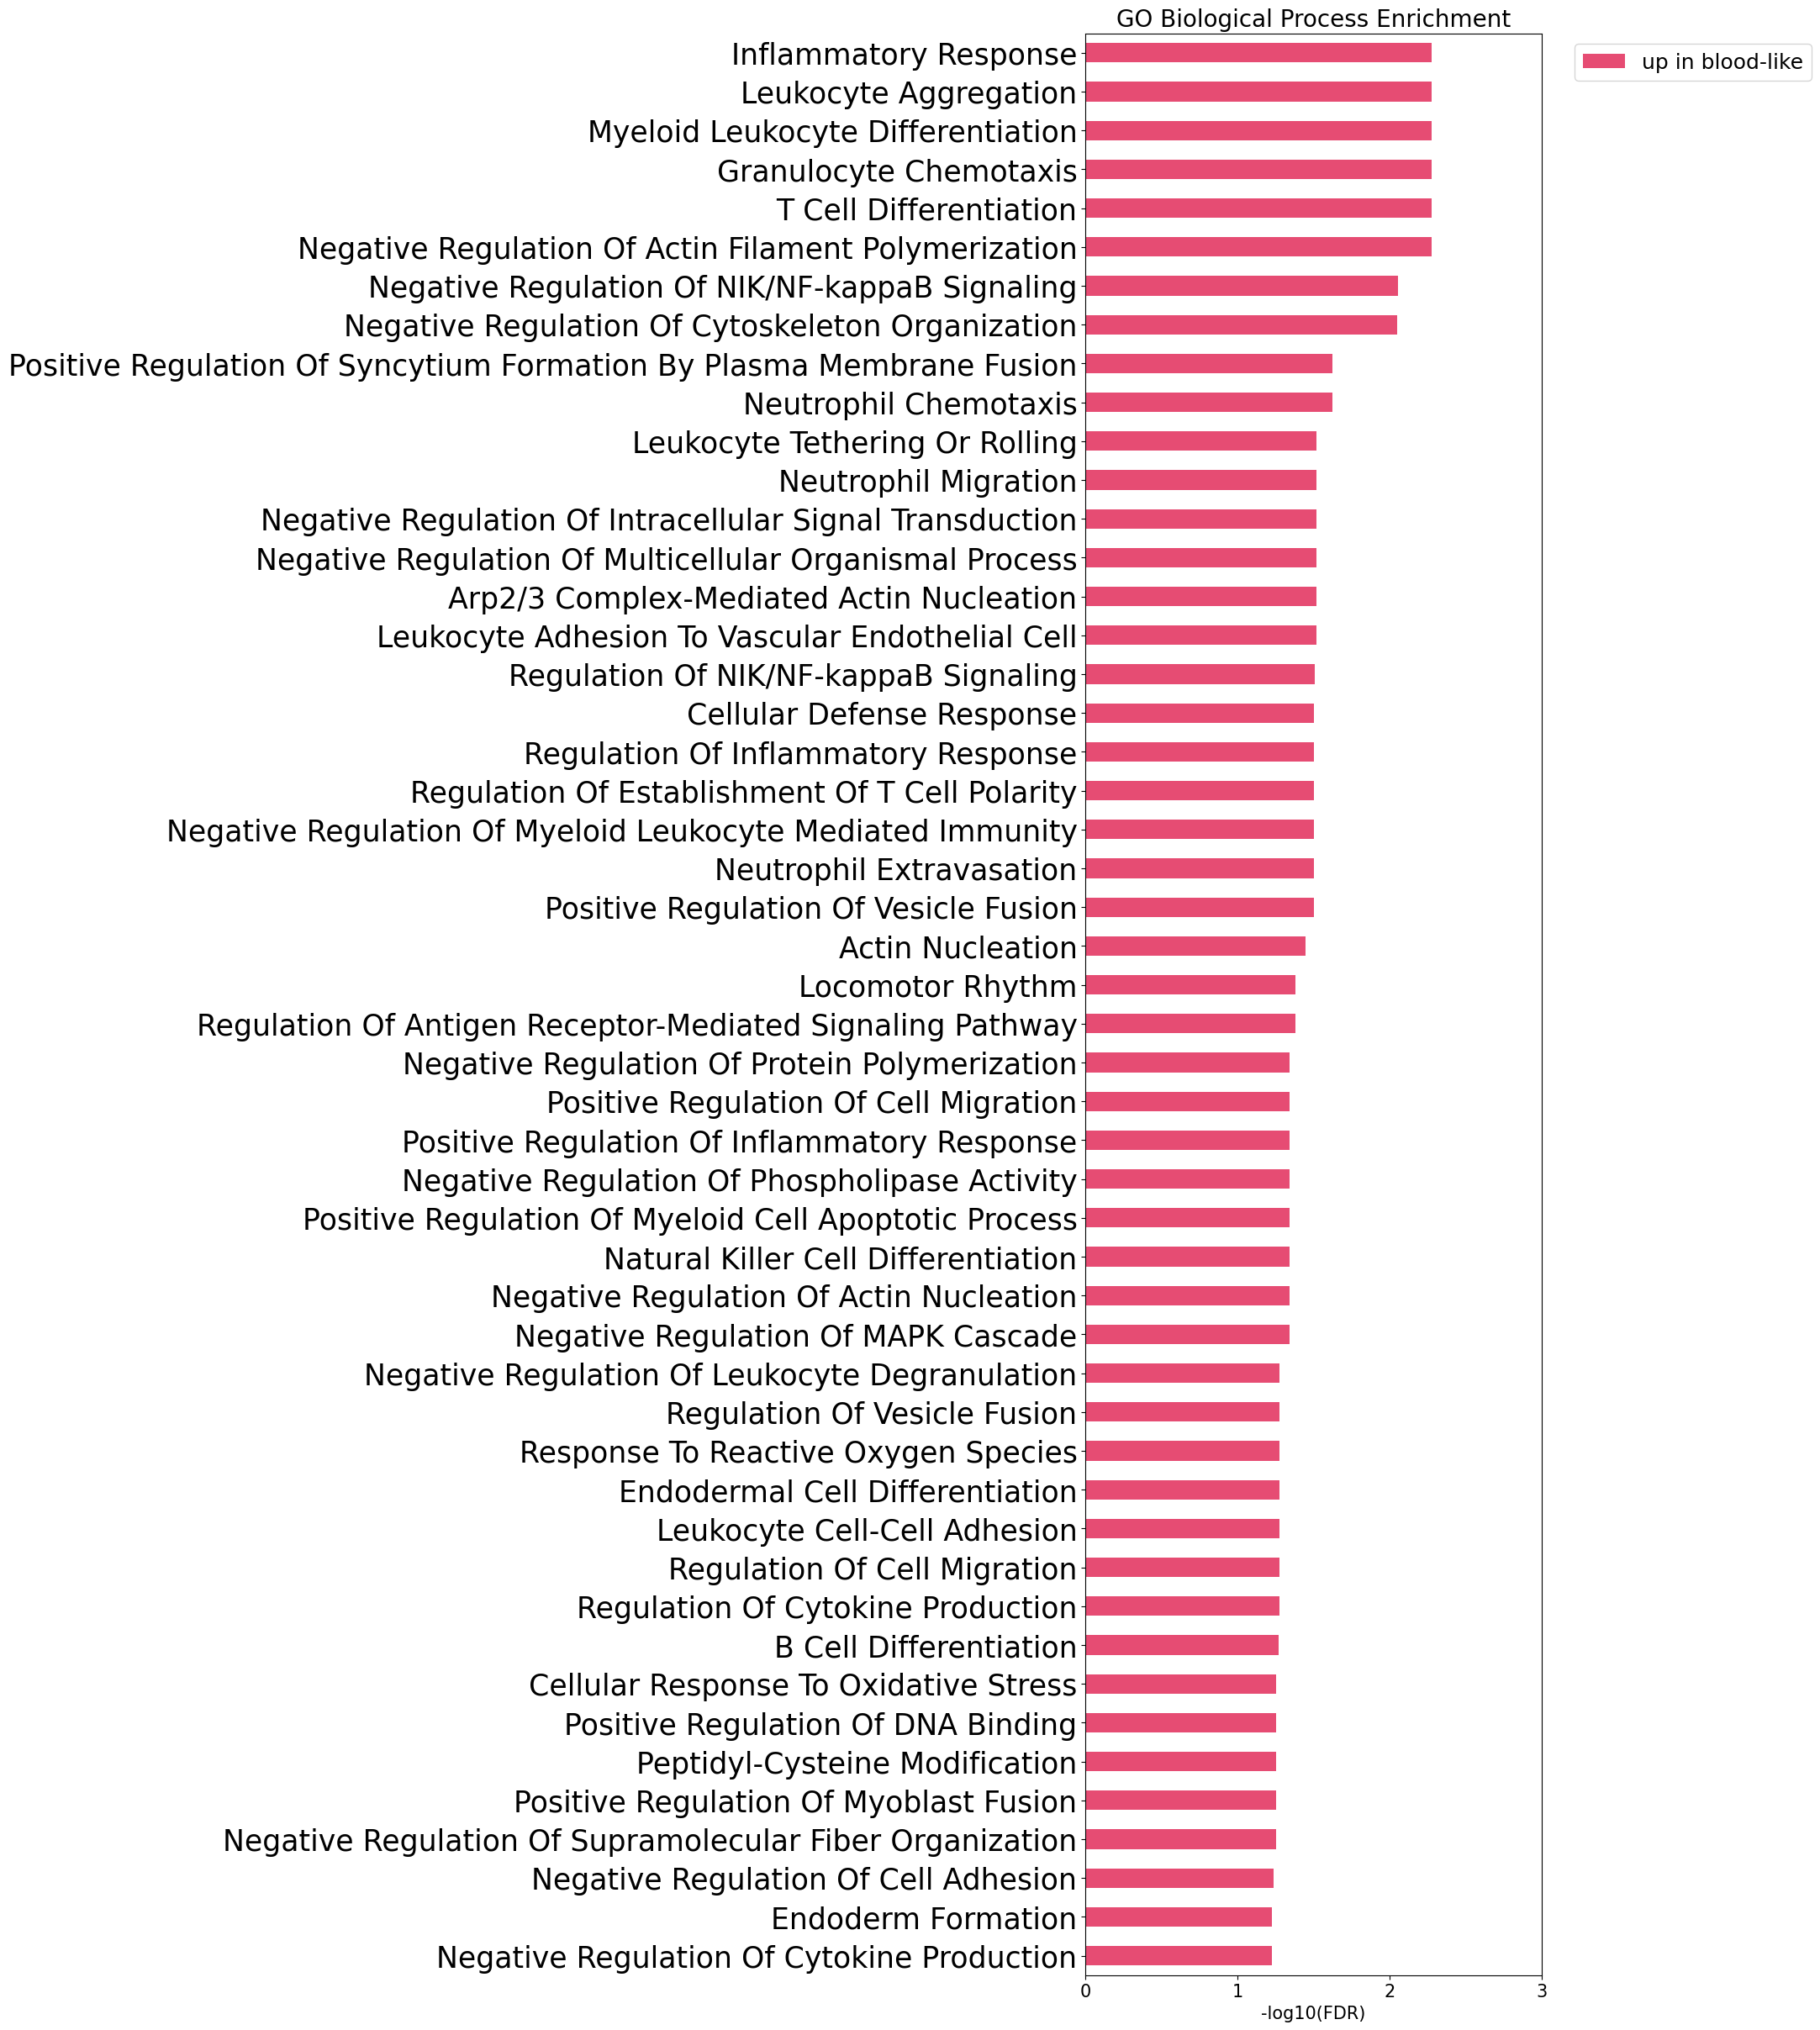

In [35]:
# Plot GO-BP
plt.figure(figsize=(7, 30))
ax = sns.barplot(
    data=go_B,
    x="-log10(FDR)",
    y="Term",
    hue="Condition",
    palette=palette
)

# --- make bars thinner but keep them centred on the tick labels ---
new_h = 0.5  # bar thickness you want
for bar in ax.patches:
    old_y = bar.get_y()
    old_h = bar.get_height()
    center = old_y + old_h / 2.0      # current centre of the bar
    bar.set_height(new_h)             # new height
    bar.set_y(center - new_h / 2.0)   # move so centre stays the same
# ------------------------------------------------------------------

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=18)
plt.title("GO Biological Process Enrichment", fontsize=20)
plt.xlabel("-log10(FDR)", fontsize=15)
plt.ylabel("")
plt.xticks(fontsize=15)
plt.yticks(fontsize=25)

xmax = ax.get_xlim()[1]
plt.xticks(ticks=np.arange(0, int(np.ceil(xmax)) + 0.1, 1), fontsize=15)

plt.show()